# TASAM: Sentiment Analysis, Data Analysis

## 1. Import libraries and load data

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


import nltk
import string
import tweepy
import twitter
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
tw_corpus = pd.read_csv('./data/tw_corpus.csv', index_col=0)
tw_corpus.head()

,Tweets,Name
0,The coronavirus ’ fit templates 9/11 invasions...,Afghanistan
1,The man gun hand jail time memory shrapnel sca...,Afghanistan
2,Pakistan 's interior ministry said close count...,Afghanistan
3,Afghanistan ’ Kashmir Fallout How likely US wi...,Afghanistan
4,"Afghanistan preparing release 1,500 Taliban pr...",Afghanistan


## 2. Data preprocessing

In [3]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    tweet_blob = normalization(no_punc_tweet)
    
    return ' '.join(tweet_blob)

In [4]:
tw_corpus['Tweets'] = tw_corpus['Tweets'].apply(text_processing)

In [5]:
tw_corpus.head()

,Tweets,Name
0,coronavirus fit templates invasions Afghanista...,Afghanistan
1,man gun hand jail time memory shrapnel scar gu...,Afghanistan
2,Pakistan interior ministry say close country b...,Afghanistan
3,Afghanistan Kashmir Fallout likely US withdraw...,Afghanistan
4,Afghanistan prepare release Taliban prisoners ...,Afghanistan


## 3. Sentiment Analysis

In [6]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity #Subjectivity tells us if text is an opinion or a fact.

def get_polarity(text):
    return TextBlob(text).sentiment.polarity #Polarity tells us if text is positive or negative.

In [7]:
tw_corpus['Subjectivity'] = tw_corpus['Tweets'].apply(get_subjectivity)
tw_corpus['Polarity'] = tw_corpus['Tweets'].apply(get_polarity)

In [8]:
tw_corpus.head()

,Tweets,Name,Subjectivity,Polarity
0,coronavirus fit templates invasions Afghanista...,Afghanistan,0.48,0.240000
1,man gun hand jail time memory shrapnel scar gu...,Afghanistan,0.25,0.050000
2,Pakistan interior ministry say close country b...,Afghanistan,0.50,0.136364
3,Afghanistan Kashmir Fallout likely US withdraw...,Afghanistan,1.00,0.000000
4,Afghanistan prepare release Taliban prisoners ...,Afghanistan,0.00,0.000000


### 3.1 Word Cloud (just for fun)

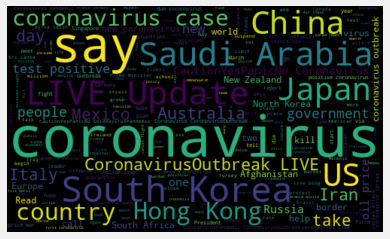

In [9]:
all_words = ' '.join([twts for twts in tw_corpus['Tweets']])
word_cloud = WordCloud(width=500, height=300, random_state=21, max_font_size=150).generate(all_words)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3.2 Sentiment Analysis - Category and Grouping

In [10]:
def sentiment_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [11]:
tw_corpus['Analysis'] = tw_corpus['Polarity'].apply(sentiment_analysis)

In [12]:
tw_corpus.head()

,Tweets,Name,Subjectivity,Polarity,Analysis
0,coronavirus fit templates invasions Afghanista...,Afghanistan,0.48,0.240000,Positive
1,man gun hand jail time memory shrapnel scar gu...,Afghanistan,0.25,0.050000,Positive
2,Pakistan interior ministry say close country b...,Afghanistan,0.50,0.136364,Positive
3,Afghanistan Kashmir Fallout likely US withdraw...,Afghanistan,1.00,0.000000,Neutral
4,Afghanistan prepare release Taliban prisoners ...,Afghanistan,0.00,0.000000,Neutral


In [13]:
def new_score(name):
    country = tw_corpus.loc[(tw_corpus['Name'] == name)]
    
    old_value = country['Polarity'].sum()
    old_score_max = country['Polarity'].max()
    old_score_min = country['Polarity'].min()
    
    old_range = old_score_max - old_score_min
    
    new_score_max = 5.0
    new_score_min = 0.0
    
    new_range = new_score_max - new_score_min

    new_value = ((old_value - old_score_min) * new_range / old_range) + new_score_min

    return new_value


In [14]:
tw_score = pd.DataFrame(columns=['Name','Score'])

for i in tw_corpus.Name:
    if i == i:
        tw_score = tw_score.append([{'Name': i},{'Score': new_score(i)}], ignore_index=True)
    else:
        break

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [15]:
tw_score['Score'] = tw_score['Score'].shift(-1)
tw_score = tw_score.dropna(axis=0,how='all')
tw_score = tw_score.drop_duplicates(subset ='Name', keep ='first')
tw_score.reset_index(drop=True)

,Name,Score
0,Afghanistan,5.628042
1,Albania,NaN
2,Algeria,NaN
3,Angola,NaN
4,Argentina,3.218012
5,Australia,21.414665
6,Austria,2.242424
7,Bahrain,9.720737
8,Bangladesh,3.846154
9,Belgium,4.383838


## 3.3 Plotting sentiment analysis

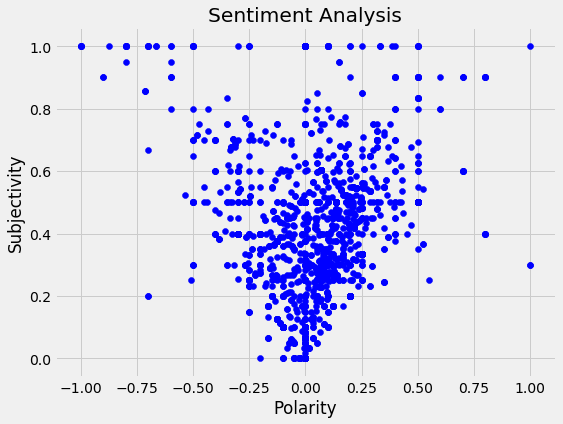

In [16]:
plt.figure(figsize=(8,6))
for i in range(0, tw_corpus.shape[0]):
    plt.scatter(tw_corpus['Polarity'][i], tw_corpus['Subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()